In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models

In [2]:
t_pipeline = transforms.Compose([ 
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
   transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
  transforms.Resize((224, 224)),          
      transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5],) 
])

In [3]:
train_dataset = datasets.ImageFolder(root='/kaggle/input/medical-image/Training', transform=t_pipeline)
test_dataset = datasets.ImageFolder(root='/kaggle/input/medical-image/Testing', transform=t_pipeline)

In [4]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /kaggle/input/medical-image/Training
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [5]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1311
    Root location: /kaggle/input/medical-image/Testing
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


In [8]:
model.fc = nn.Linear(model.fc.in_features, 4)

In [9]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images, labels

        optimizer.zero_grad() 

      
        outputs = model(images)
        loss = criterion(outputs, labels)

     
        loss.backward()
        optimizer.step()

       
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/5], Loss: 0.2546, Accuracy: 90.97%
Epoch [2/5], Loss: 0.1088, Accuracy: 96.32%
Epoch [3/5], Loss: 0.0767, Accuracy: 97.53%
Epoch [4/5], Loss: 0.0574, Accuracy: 98.11%
Epoch [5/5], Loss: 0.0456, Accuracy: 98.39%


In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
model.eval()
correct_preds = 0
total_preds = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs, labels
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels)
        total_preds += labels.size(0)

test_accuracy = correct_preds.double() / total_preds
print(f"Validation Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.9802


In [12]:
from sklearn.metrics import f1_score

correct_preds = 0
total_preds = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs, labels
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())


f1 = f1_score(all_labels, all_preds, average='weighted')  
print(f"F1 Score: {f1:.4f}")




F1 Score: 0.9825


In [13]:
torch.save(model.state_dict(), 'resnet50_brain_tumor.pth')

Predicted class index: 3
Predicted class label: Pituitary Tumor


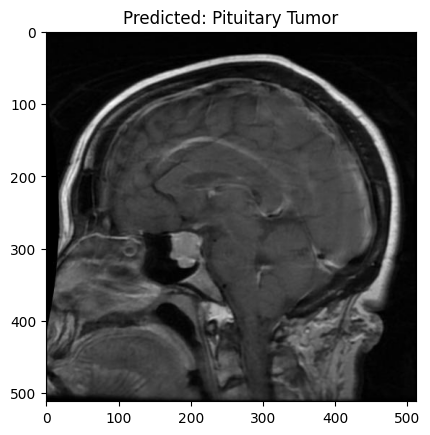

In [60]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn


class_labels = {
    0: "Glioma",
    1: "Meningioma",
    2: "No Tumor",
    3: "Pituitary Tumor"
}


model = models.resnet50(pretrained=False)


model.fc = nn.Linear(model.fc.in_features, 4)


model.load_state_dict(torch.load('/kaggle/working/resnet50_brain_tumor.pth', weights_only=True), strict=False)


model.eval()

t_pipeline = transforms.Compose([ 
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
   transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
  transforms.Resize((224, 224)),          
      transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5],) 
])





image_path = '/kaggle/input/medical-image/Testing/pituitary/Te-piTr_0005.jpg' 
image = Image.open(image_path)
image_tensor = t_pipeline(image).unsqueeze(0)  


with torch.no_grad(): 
    output = model(image_tensor)


_, predicted_class_index = torch.max(output, 1)


predicted_label = class_labels[predicted_class_index.item()]

print(f'Predicted class index: {predicted_class_index.item()}')
print(f'Predicted class label: {predicted_label}')


plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.show()


Predicted class index: 3
Predicted class label: Pituitary Tumor
Prediction Confidence: 0.9980


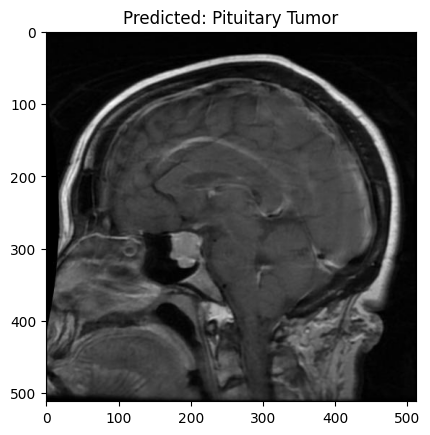

In [62]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn


class_labels = {
    0: "Glioma",
    1: "Meningioma",
    2: "No Tumor",
    3: "Pituitary Tumor"
}


model = models.resnet50(pretrained=False)


model.fc = nn.Linear(model.fc.in_features, 4)



model.load_state_dict(torch.load('/kaggle/working/resnet50_brain_tumor.pth', weights_only=True), strict=False)


model.eval()

t_pipeline = transforms.Compose([ 
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
   transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
  transforms.Resize((224, 224)),          
      transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5],) 
])





image_path = '/kaggle/input/medical-image/Testing/pituitary/Te-piTr_0005.jpg' 
image = Image.open(image_path)
image_tensor = t_pipeline(image).unsqueeze(0)  


with torch.no_grad(): 
    output = model(image_tensor)

softmax = torch.nn.Softmax(dim=1)
probabilities = softmax(output)

# Get the predicted class index (class with the highest probability)
predicted_class_index = torch.argmax(probabilities, 1)
predicted_probability = probabilities[0, predicted_class_index.item()]

# Set a confidence threshold (e.g., 0.6) to predict "No Tumor" only if confident enough
confidence_threshold = 0.6
predicted_label = class_labels[predicted_class_index.item()]
if predicted_label == "No Tumor" and predicted_probability < confidence_threshold:
    predicted_label = "Uncertain: No Tumor"
    predicted_class_index = -1  # Indicating low confidence

# Print the predicted class information
print(f'Predicted class index: {predicted_class_index.item()}')
print(f'Predicted class label: {predicted_label}')
print(f'Prediction Confidence: {predicted_probability.item():.4f}')



plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.show()
